# 👖 Autoencoders on Fashion MNIST

* Строим автокодировщик - модель, которая состоит из кодировщика и декодировщика.
* Кодировщик - сжимает входнные даные в векторное предстваление меньшей размерности (скрытое пространство), например - точки на плоскости.
* Декодировщик - распаковывает заданное векторное пространство в исходное состояние.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1 #кол-во каналов цветов
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2 #размерность выходного вектора кодировщика (скрытое пространство)
EPOCHS = 3

## 1. Prepare the data <a name="prepare"></a>

(60000, 28, 28)
(60000,)


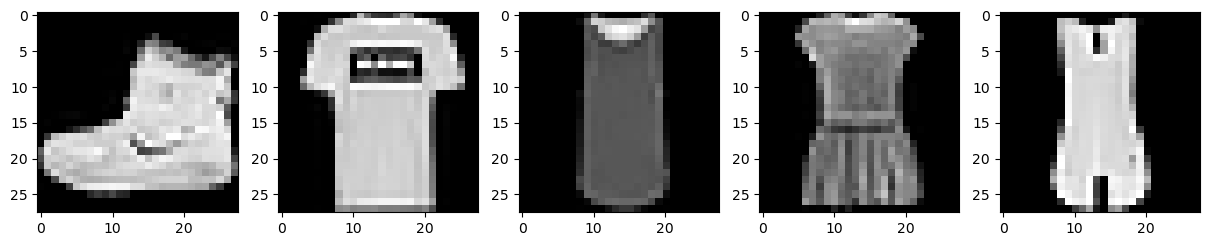

In [3]:
#датасет с изображениями одежды, 60000 черно-белых картинок 28х28
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

print(x_train.shape)
print(y_train.shape)

#посмотрим примеры данных, тут стоит указать cmap="gray" иначе изображения будут зелено-синие
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(x_train[0], cmap="gray")
ax = fig.add_subplot(1, 5, 2)
ax.imshow(x_train[1], cmap="gray")
ax = fig.add_subplot(1, 5, 3)
ax.imshow(x_train[2], cmap="gray")
ax = fig.add_subplot(1, 5, 4)
ax.imshow(x_train[3], cmap="gray")
ax = fig.add_subplot(1, 5, 5)
ax.imshow(x_train[4], cmap="gray");

In [4]:
# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0 #нормализуем
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) #делаем картинки 32х32 для упощения дальнейших операций
    imgs = np.expand_dims(imgs, -1) #расширяем размерность, добавляем столбец, чтобы были данные о кол-ве каналов 
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

print(x_train.shape)

(60000, 32, 32, 1)


## 2. Build the autoencoder <a name="build"></a>

In [6]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
#добавляем три слоя свертки с шагом 2, сжимая картинку до размера 4х4
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

#чтобы потом восстановить картинку нужно запомнить размерность до которой мы её сжали
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
#кол-во выходов 2 - координаты точки на плоскости в скрытом пространстве
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)

encoder.summary();

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

In [7]:
# Decoder
#вход - координаты точки (вектора) из кодировщика
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) #плоский вектор 
x = layers.Reshape(shape_before_flattening)(x) #из плоского вектора получаем "изображение" обратно

#три слоя ОБРАТНОЙ свертки, шаг=2 - увеличивает размер выходного изображения в 2 раза
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

#выход - слой финальной свертки, шаг=1, активация - сигмойда, чтобы не терять пикселы (релу может просто их обнулить)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [8]:
# Autoencoder
#выходные данные автокодировщика - выходные данные кодировщика, обработанные декодировщиком
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_2 (Functional)        (None, 32, 32, 1)         2462

## 3. Train the autoencoder <a name="train"></a>

In [10]:
# Compile the autoencoder
#тут функция потерь либо RMSE либо бинарная кросс-энтропия между исходными и восстановленными пикселами
#RMSE - моет давать более "пиксельное" изображение
#binary_crossentropy - дает более размытую картинку, тут что нужнее
autoencoder.compile(optimizer="adam", loss="binary_crossentropy");

In [ ]:
# если хотим сохранять веса модели
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath="checkpoint",
#     save_weights_only=False,
#     save_freq="epoch",
#     monitor="loss",
#     mode="min",
#     save_best_only=True,
#     verbose=0,
# )
#tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [12]:
autoencoder.fit(
    x_train, #тут x_train и x_train!! т.е сравниваем картинку саму с собой
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
);
    #callbacks=[model_checkpoint_callback, tensorboard_callback],

Epoch 1/3
600/600 [==============================] - 35s 58ms/step - loss: 0.2846 - val_loss: 0.2614
Epoch 2/3
600/600 [==============================] - 33s 55ms/step - loss: 0.2571 - val_loss: 0.2571
Epoch 3/3
600/600 [==============================] - 32s 53ms/step - loss: 0.2539 - val_loss: 0.2544


In [13]:
# если надо сохранить модели
# autoencoder.save("./models/autoencoder")
# encoder.save("./models/encoder")
# decoder.save("./models/decoder")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [14]:
#делаем предсказания, по сути генерируем картинки
predictions = autoencoder.predict(x_test)

313/313 [==============================] - 2s 7ms/step


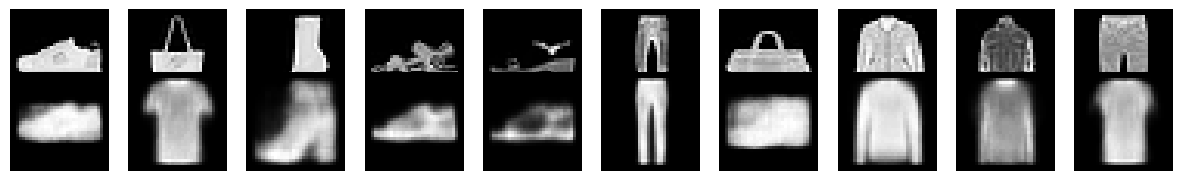

In [21]:
#визуализируем данные с их предсказаниями
n_to_show = 10
#берем 10 случайный картинок
indices = np.random.choice(range(len(x_test)), n_to_show)
fig = plt.figure(figsize=(15, 3))

#оригинальные и созданные картинки
for i, idx in enumerate(indices):
    img_orig = x_test[idx]
    img_pred = predictions[idx]
    ax = fig.add_subplot(2, n_to_show, i + 1)
    ax.axis("off")
    ax.imshow(img_orig, cmap='gray')

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.imshow(img_pred, cmap='gray')

## 5. Embed using the encoder <a name="encode"></a>

In [22]:
# примеры векторов
n_to_predict = 5000
example_images = x_test[:n_to_predict]

embeddings = encoder.predict(example_images)
print(embeddings[:5])

157/157 [==============================] - 0s 2ms/step
[[ 1.753715  -1.6929014]
 [ 4.9246955  3.4502316]
 [-2.6798902  4.9666305]
 [-1.9449749  2.9566169]
 [ 3.0465693  1.4825995]]


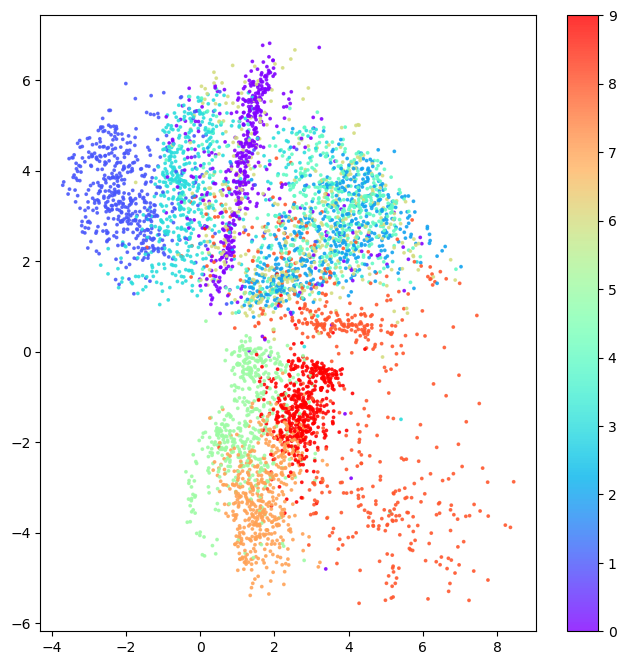

In [25]:
# визуализируем скрытое пространство, добавим цвета по классам (типы одежды)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder <a name="decode"></a>

1/1 [==============================] - 0s 28ms/step


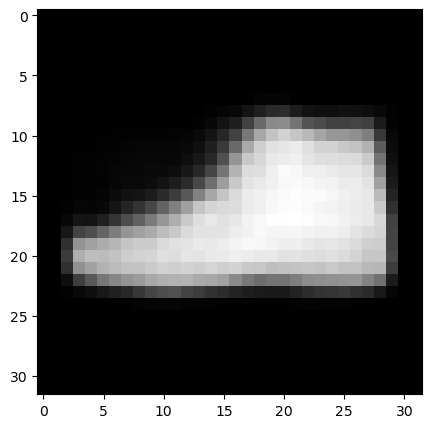

In [35]:
#диапазон значений векторов
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

#берем случайную точку в пространстве
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

# декодируем точку в изображение
reconstructions = decoder.predict(sample)

#смотрим на изображение
plt.figure(figsize=(5,5))
plt.imshow(reconstructions[0], cmap='gray');

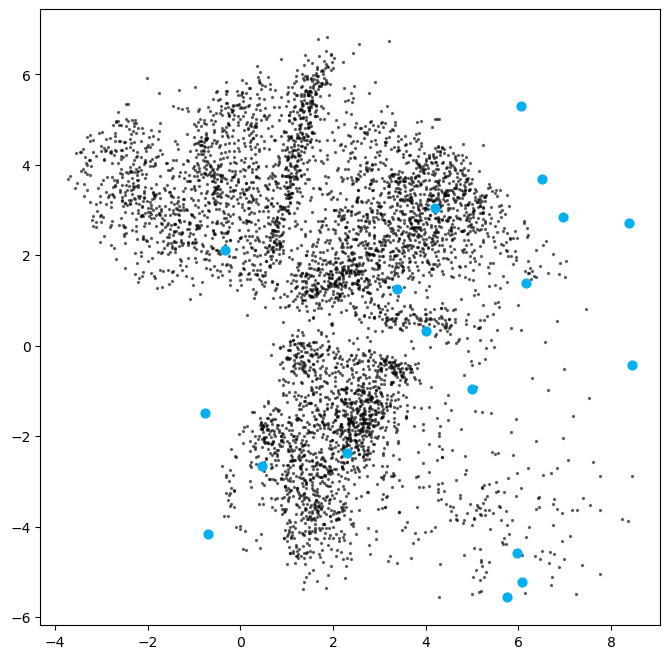

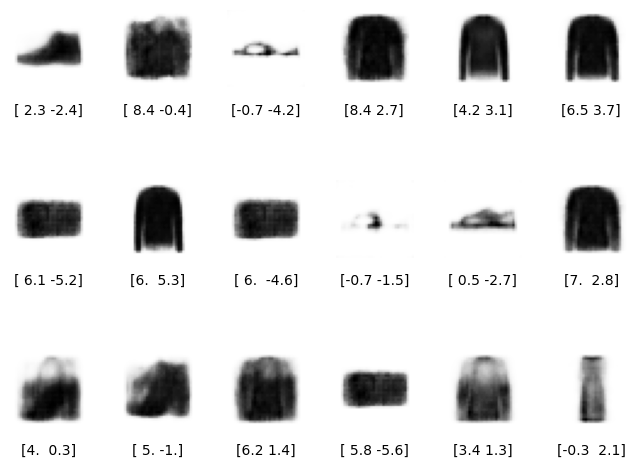

In [36]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 8ms/step


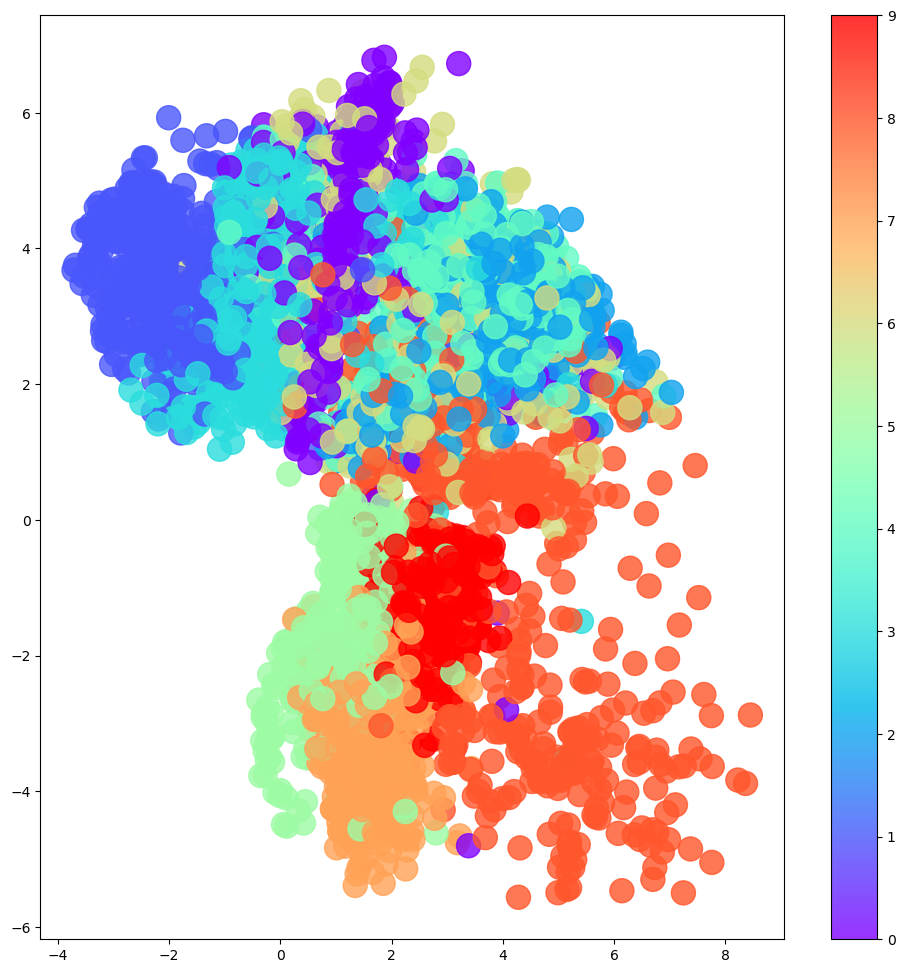

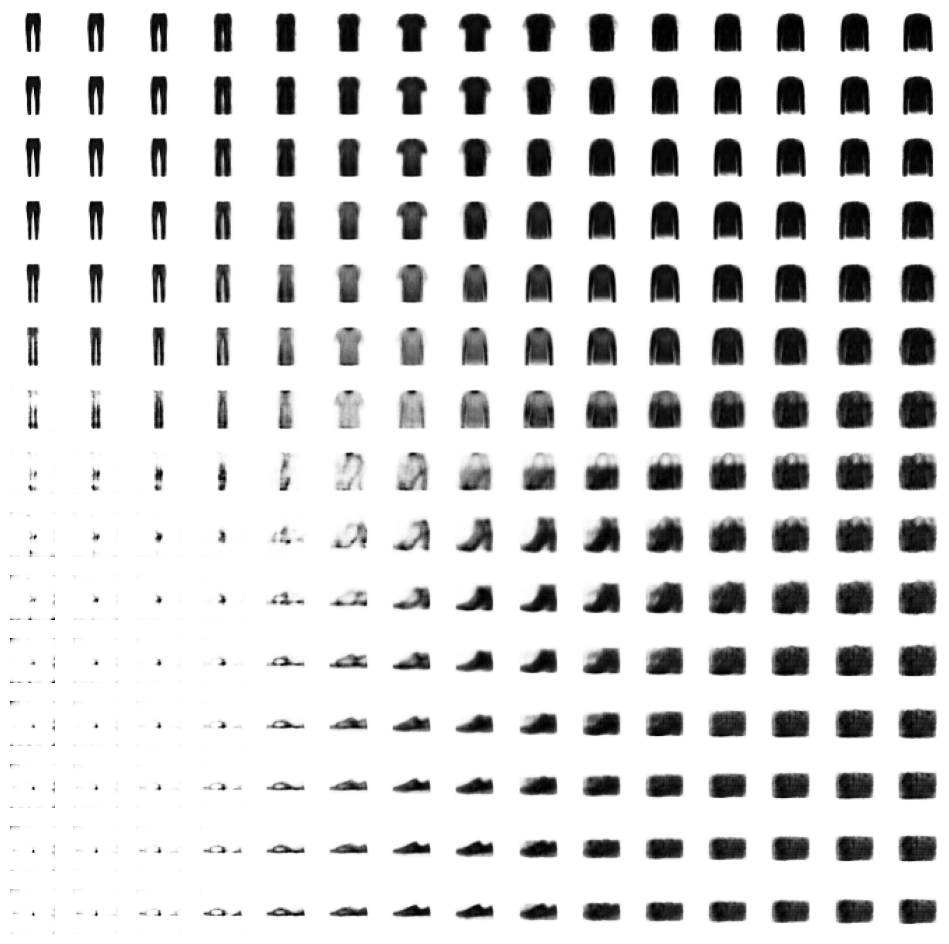

In [37]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")